In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

np.random.seed(0)

# Settings
P0 = 3.8
Pdec = 1000
tmax = 30
amp = [3.0, 1.0, 0.33]
der = [1.0, 4.0, 0.5]
nt = [15, 15, 15]


In [2]:
def func_deriv(t, p0, amp, der):
    return amp * np.sin(2 * np.pi * t / p0) + der * np.cos(2 * np.pi * t / p0) 

(15,)


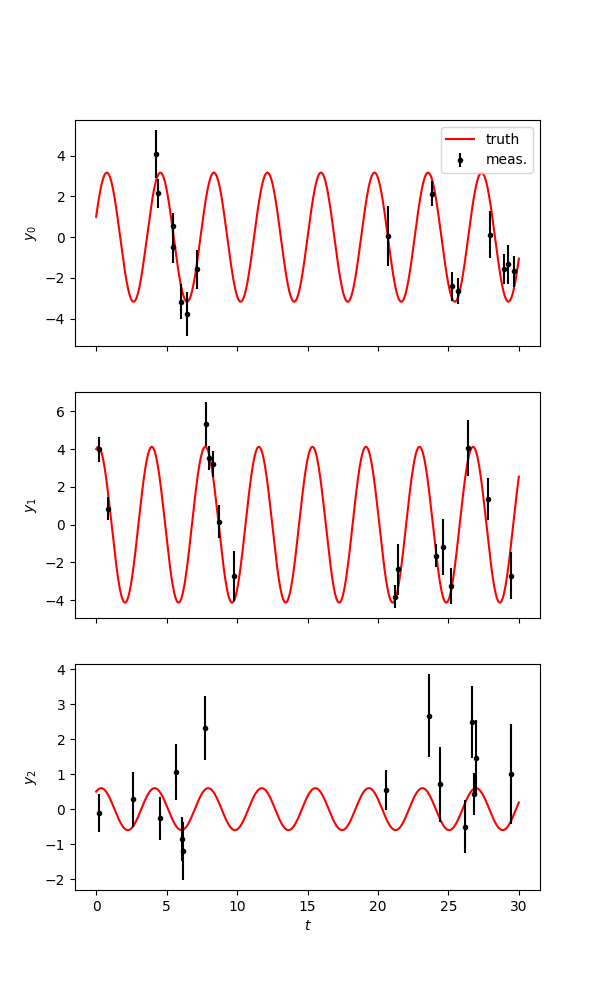

In [3]:
# True signal
tsmooth = np.linspace(0, tmax, 40000)
Ysignal = [
  func_deriv(tsmooth, P0, ak, dk)
  for ak, dk in zip(amp, der)
]


# Generate observations calendars
T = [
  np.sort(
  np.concatenate((np.random.uniform(0, tmax / 3,
  ntk // 2), np.random.uniform(2 * tmax / 3, tmax, (ntk + 1) // 2))))
  for ntk in nt
]

# Generate measurements with white noise
Yerr = [np.random.uniform(0.5, 1.5, ntk) for ntk in nt]
Y = [ func_deriv(T[k], P0, amp[k], der[k]) +
  np.random.normal(0, Yerr[k]) for k in range(3)
]

# Plot
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()

print(np.shape(T[0]))

In [49]:
## test 

test = []
Yerr_jit = []
for k in range(0,3):
    test.append(func_deriv(T[k], P0, amp[k], der[k]))
for k in range(0,3):
    Yerr_jit.append(np.sqrt(Yerr[k]**2 + 4.0000000000000000))




In [50]:
from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Merge all 3 time series
t_full, y_full, yerr_full, series_index = cov.merge_series(T, Y, Yerr)
_, _, yerr_jit, _ = cov.merge_series(T, Y, Yerr_jit)


0.007138490676879883


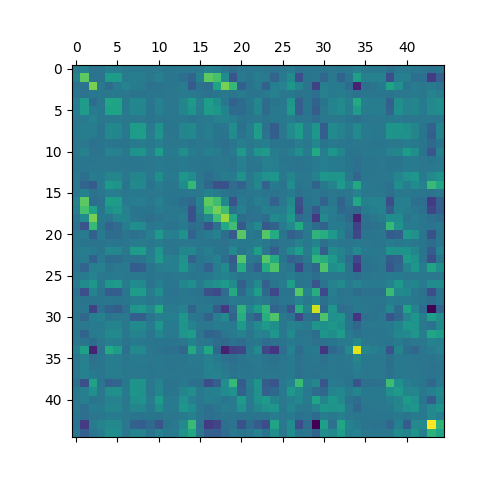

In [51]:
# Initialize the S+LEAF model
import time
time0 = time.time()
D = cov.Cov(t_full,
  err=term.Error(yerr_jit),
  GP=term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35), series_index,
  [3.0, 1.0, 0.33], [1.0, 4.0, 0.5]))
time1 = time.time()
print(time1-time0)

D_mu, D_cov = D.self_conditional(y_full, calc_cov=True)
D_loglike = D.loglike(y_full)

plt.matshow(D_cov)

0.007128000259399414
['GP.sig', 'GP.P', 'GP.rho', 'GP.eta', 'GP.alpha_0', 'GP.alpha_1', 'GP.alpha_2', 'GP.beta_0', 'GP.beta_1', 'GP.beta_2', 'jitter_inst00.sig', 'jitter_inst01.sig', 'jitter_inst02.sig']


/tmp/ipykernel_15278/634369552.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(D1_cov-D_cov)


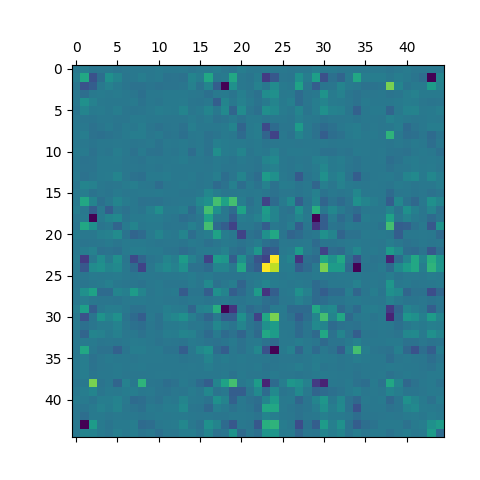

In [52]:
time0 = time.time()

kwargs = {
    'err': term.Error(yerr_full),
    'GP': term.MultiSeriesKernel(term.ESPKernel(1.0, 3.8, 1000.0, 0.35), series_index,
  [3.0, 1.0, 0.33], [1.0, 4.0, 0.5]),
    'jitter_inst00': term.InstrumentJitter(series_index[0], 2.0000000000000000),
    'jitter_inst01': term.InstrumentJitter(series_index[1], 2.0000000000000000),
    'jitter_inst02': term.InstrumentJitter(series_index[2], 2.0000000000000000),
}

D1 = cov.Cov(t_full, **kwargs)
time1 = time.time()
print(time1-time0)

print(D1.param)

D1_mu, D1_cov = D1.self_conditional(y_full, calc_cov=True)
D1_loglike = D1.loglike(y_full)

### PAY ATTENTION HERE

plt.matshow(D1_cov-D_cov)

In [53]:
print(D_loglike)
print(D1_loglike)

-90.85838453538447
-90.85838453538449


In [54]:
D1_param = D1.param[1:]

D1_values = [ 3.8,
          2000,
          0.35,
          3.0, 1.0, 0.33, 1.0, 4.0, 0.5, 2.0, 2.0, 2.0]

D1.set_param(D1_values, D1_param)

D1_new_mu, D1_new_cov = D1.self_conditional(y_full, calc_cov=True)

D1_new_loglike = D1.loglike(y_full)
print(D1_new_loglike-D1_loglike)
print(D1_new_loglike)
print(D1_loglike)

0.005826151931643153
-90.85255838345284
-90.85838453538449


In [26]:
D_param = D.param[1:]

D_values = [  3.8,
          2000,
          0.35,
          3.0, 1.0, 0.33, 1.0, 4.0, 0.5,]

D.set_param(D_values, D_param)

D_new_mu, D_new_cov = D.self_conditional(y_full, calc_cov=True)

D_new_loglike = D.loglike(y_full)
print(D_new_loglike-D_loglike)

0.005826151931628942


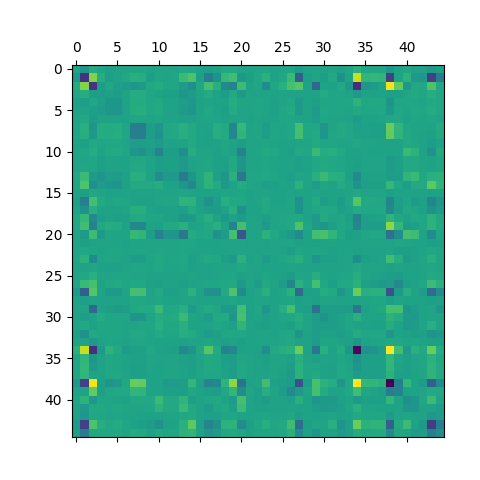

In [27]:
plt.matshow(D_new_cov-D_cov)

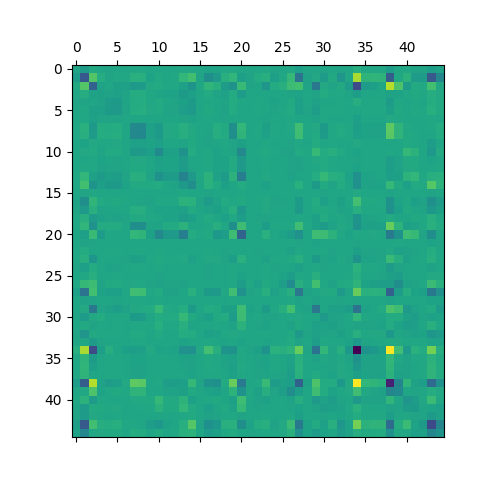

In [14]:
plt.matshow(D1_new_cov-D1_cov)

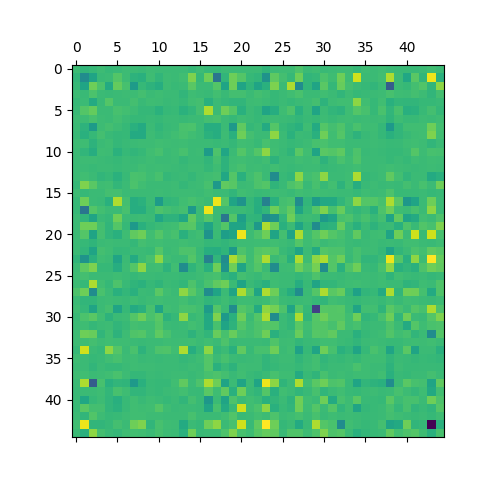

In [15]:
plt.matshow(D1_new_cov-D_new_cov)

In [40]:
print(np.asarray(D_diag))


[[ 2.61083617  0.13799523 -0.21717632 -0.24662887 -2.37143333 -2.22192381
   2.27677583  2.56087998  1.40227516 -2.21970661 -2.41625937  2.59974872
   2.61417939  2.60829692  0.408716   -2.13052753  0.48353012  1.8296716
   1.10992288 -2.2644591   0.89076832  1.1298214   1.98730481  2.25770556
  -0.38991415 -1.66700311 -2.44073586 -2.39296805 -1.79899246  1.62499933
   2.60824172  2.04349177  1.77835262 -1.77389432 -2.44532763 -2.46663621
   2.55106549 -1.90349527  1.55093681  1.94889825  1.09330993  0.98812162
  -1.33121955 -1.37375145 -2.4813282  -2.29638634 -0.28187229  2.13297242
   2.62815    -2.48751321 -1.05898264  2.40879942  2.20580775  0.92659147
  -0.86979171 -2.38941531 -2.47536526  1.31605709  1.68447732  1.77628234
   2.45017611  2.62401977  2.61859915  2.56594178  2.0226215   0.76012695
  -0.16888684 -0.72471464 -2.44287491 -1.78869438 -1.39335196 -0.42575092
   0.71474355  1.67428623  0.63006968  0.10684489 -2.07481075  0.5184858
   2.45579688  2.44912298  1.03797738 -0

In [39]:
print(np.asarray(D_diag)-np.asarray(D_diagNEW))
np.shape(D_diag)

[[-1.05574351e-02  5.21375807e-03  8.24633745e-03  8.49465932e-03
   1.99246966e-02  1.49755383e-02 -5.36663065e-03 -1.08134322e-02
  -4.84519917e-03  1.89521082e-02  1.55386154e-02 -8.30605203e-03
  -8.67500919e-03 -9.55304232e-03  2.85318105e-03  1.76761302e-02
   4.85094314e-03 -6.34905993e-03 -1.95569566e-03  1.20058424e-02
   3.44258769e-03  2.57204161e-03 -1.44960981e-03 -7.50346189e-03
   7.87974323e-03  1.43450828e-02  1.23242487e-02  1.18236309e-02
   9.34535147e-03  7.77671546e-04 -5.81247297e-03 -5.93175783e-03
  -4.78074886e-03  1.35969232e-02  1.31132382e-02  1.28364065e-02
  -4.22911863e-03  7.93085479e-03  1.61754140e-03  8.87556527e-05
  -6.10789588e-04 -1.14648655e-04  1.03971006e-02  1.05310653e-02
   9.63614432e-03  8.15293116e-03  5.35295388e-03 -2.92260931e-04
  -4.02487526e-03  9.00981792e-03  5.58235745e-03 -3.85849689e-03
  -3.56631509e-03  5.70521800e-04  7.41114969e-03  8.97133932e-03
   7.36277565e-03  2.77031325e-03  1.94263740e-03  1.70122232e-03
  -8.16147

(2, 225)

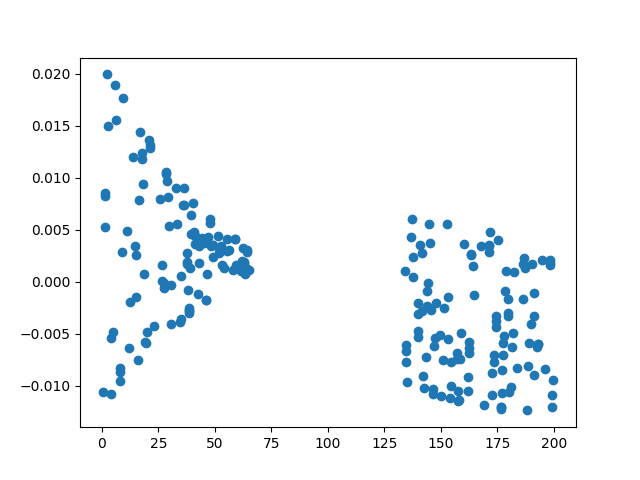

In [41]:
plt.figure()
plt.scatter(t_full, D_diag[0]-D1_diag[0])
plt.show()

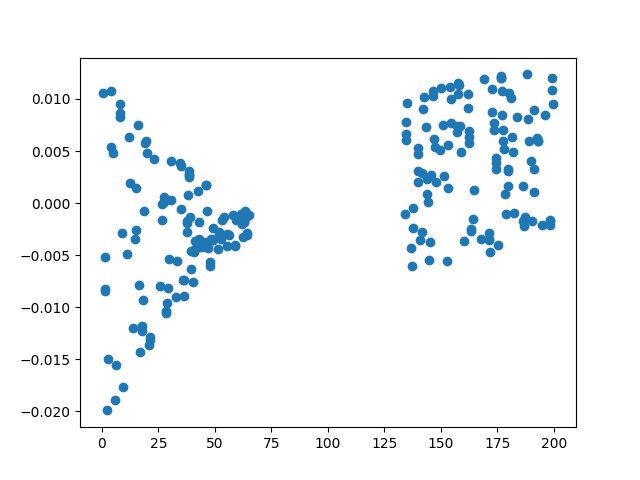

In [43]:
plt.figure()
plt.scatter(t_full, D_diagNEW[0]-D_diag[0])
plt.show()

In [30]:
# Fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.param
# List of parameters to fit
param = D.param[1:]
# The amplitude of the kernel is fixed at 1 (not fitted),
# since it would be degenerated with the amplitudes alpha, \beta.


bounds = np.zeros([len(param),2])
bounds[4:,0] = -10
bounds[:,1] = 220
bounds[10:,0] = 0.0
bounds[10:,1] = 2.0

bounds[0,:] = [1.6, 10.2]
bounds[1,:] = [500, 2000]
bounds[2,:] = [0, 0.50]
bounds[3,:] = [0, 0.50]

y = y_full

# Define the function to minimize
def negloglike(x, y, D):
  D.set_param(x, param)
  nll = -D.loglike(y)
  # gradient
  nll_grad = -D.loglike_grad()[1][1:]
  return (nll, nll_grad)

def pyde_function(x):
  #print(x)
  sel = (x < bounds[:,0]) | (x>bounds[:,1])
  if np.sum(sel) > 0:
    return -np.inf
  D.set_param(x, param)
  ll = D.loglike(y)
  return ll


from pyde.de import DiffEvol
de = DiffEvol(pyde_function, bounds, 50, maximize=True)
res = de.optimize(ngen=510000)




In [31]:
print(bounds)
print(res)
print(param)




[[ 1.60e+00  1.02e+01]
 [ 5.00e+02  2.00e+03]
 [ 0.00e+00  5.00e-01]
 [ 0.00e+00  5.00e-01]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]
 [-1.00e+01  2.20e+02]]
(array([ 7.60007147e+00,  1.99927790e+03,  3.54519272e-03,  1.69704727e-01,
       -1.83020765e+00, -2.46415844e-01,  1.06059353e+00,  8.97139455e-01,
        1.34864401e-01]), 55157.154001213275)
['GP.P', 'GP.rho', 'GP.eta', 'GP.alpha_0', 'GP.alpha_1', 'GP.alpha_2', 'GP.beta_0', 'GP.beta_1', 'GP.beta_2']


In [ ]:


# Fit
#xbest, _, _ = fmin_l_bfgs_b(negloglike, D.get_param(param), args=(y_full, D))

xbest = res[0]
print(xbest)
# Use S+LEAF to predict the missing data

D.set_param(xbest, param)
_, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 10))
for k in range(3):
  # Predict time series k
  D.kernel['GP'].set_conditional_coef(series_id=k)
  mu, var = D.conditional(y_full, tsmooth, calc_cov='diag')

  # Plot
  ax = axs[k]
  ax.plot(tsmooth, Ysignal[k], 'r', label='truth')
  ax.errorbar(T[k], Y[k], Yerr[k], fmt='.', color='k', label='meas.')
  ax.fill_between(tsmooth,
    mu - np.sqrt(var),
    mu + np.sqrt(var),
    color='g',
    alpha=0.5)
  ax.plot(tsmooth, mu, 'g', label='predict.')
  ax.set_ylabel(f'$y_{k}$')
ax.set_xlabel('$t$')
axs[0].legend()
plt.show()

[ 7.60007147e+00  1.99927790e+03  3.54519272e-03  1.69704727e-01
 -1.83020765e+00 -2.46415844e-01  1.06059353e+00  8.97139455e-01
  1.34864401e-01]
